In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [38]:
data = pd.read_csv('2dataset.csv')
data = data.sample(frac=0.1, random_state=42)


In [39]:
# Пользовательский kNN классификатор
class CustomKNN:
    def __init__(self, k=5, distance_metric='euclidean'):
        self.k = k
        self.distance_metric = distance_metric
        self.X_train = None
        self.y_train = None
    
    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)
    
    def _distance(self, x1, x2):
        if self.distance_metric == 'euclidean':
            return np.sqrt(np.sum((x1 - x2) ** 2))
        elif self.distance_metric == 'manhattan':
            return np.sum(np.abs(x1 - x2))
        else:
            raise ValueError("Поддерживаются только 'euclidean' и 'manhattan'")
    
    def predict(self, X):
        X = np.array(X)
        predictions = []
        for x in X:
            distances = [self._distance(x, x_train) for x_train in self.X_train]
            k_indices = np.argsort(distances)[:self.k]
            k_nearest_labels = self.y_train[k_indices]
            most_common = Counter(k_nearest_labels).most_common(1)[0][0]
            predictions.append(most_common)
        return np.array(predictions)

In [40]:
# Пользовательские функции для метрик
def confusion_matrix_custom(y_true, y_pred):
    TP = sum((t == 1 and p == 1) for t, p in zip(y_true, y_pred))
    TN = sum((t == 0 and p == 0) for t, p in zip(y_true, y_pred))
    FP = sum((t == 0 and p == 1) for t, p in zip(y_true, y_pred))
    FN = sum((t == 1 and p == 0) for t, p in zip(y_true, y_pred))
    return [[TN, FP], [FN, TP]]

def accuracy_custom(y_true, y_pred):
    correct = sum(t == p for t, p in zip(y_true, y_pred))
    total = len(y_true)
    return correct / total if total > 0 else 0

def precision_custom(y_true, y_pred):
    cm = confusion_matrix_custom(y_true, y_pred)
    TP = cm[1][1]
    FP = cm[0][1]
    return TP / (TP + FP) if (TP + FP) > 0 else 0

def recall_custom(y_true, y_pred):
    cm = confusion_matrix_custom(y_true, y_pred)
    TP = cm[1][1]
    FN = cm[1][0]
    return TP / (TP + FN) if (TP + FN) > 0 else 0

def f1_custom(y_true, y_pred):
    precision = precision_custom(y_true, y_pred)
    recall = recall_custom(y_true, y_pred)
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

In [41]:
# Подготовка данных
X = data.drop(columns=['RainTomorrow', 'Date', 'Location'])
y = data['RainTomorrow'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
class_distribution = Counter(y)
class_ratio = y.value_counts().max() / y.value_counts().min()
print(class_ratio)

5.109489051094891


In [ ]:
# Балансировка классов
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

In [43]:
# Классификаторы
classifiers = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Custom kNN (k=5)': CustomKNN(k=5, distance_metric='euclidean'),
    'Naive Bayes': GaussianNB(),
    'SVM Linear': SVC(kernel='linear', probability=True, random_state=42),
    'SVM Polynomial': SVC(kernel='poly', degree=3, probability=True, random_state=42),
    'SVM RBF': SVC(kernel='rbf', probability=True, random_state=42),
    'SVM Sigmoid': SVC(kernel='sigmoid', probability=True, random_state=42)
}

# Оценка метрик и сбор данных для ROC
results = {}
roc_data = {}
for name, clf in classifiers.items():
    clf.fit(X_train_scaled, y_train_balanced)
    y_pred = clf.predict(X_test_scaled)
    
    # Пользовательские метрики
    results[name] = {
        'Accuracy': accuracy_custom(y_test, y_pred),
        'Precision': precision_custom(y_test, y_pred),
        'Recall': recall_custom(y_test, y_pred),
        'F1': f1_custom(y_test, y_pred),
        'Confusion Matrix': confusion_matrix_custom(y_test, y_pred)
    }
    
    # ROC AUC (только для моделей с predict_proba)
    if hasattr(clf, 'predict_proba'):
        y_prob = clf.predict_proba(X_test_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        results[name]['ROC AUC'] = roc_auc
        roc_data[name] = (fpr, tpr, roc_auc)

In [44]:
# Визуализация: Зависимость точности Custom kNN от k
k_values = range(1, 11)
knn_accuracies = []
for k in k_values:
    knn = CustomKNN(k=k, distance_metric='euclidean')
    knn.fit(X_train_scaled, y_train_balanced)
    y_pred = knn.predict(X_test_scaled)
    knn_accuracies.append(accuracy_custom(y_test, y_pred))



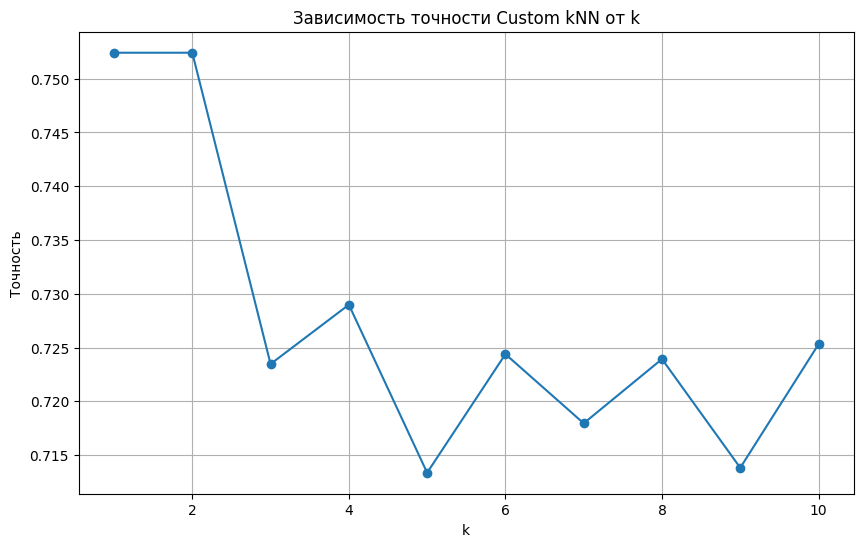

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, knn_accuracies, marker='o')
plt.xlabel('k')
plt.ylabel('Точность')
plt.title('Зависимость точности Custom kNN от k')
plt.grid(True)
plt.show()

При k = 1 и k = 2 точность высокая (около 0.75). При малых k модель сильно подстраивается под ближайшие точки, что может хорошо работать, если данные имеют четкие границы классов, но это также может приводить к переобучению. Резкое падение при k = 3: Точность падает до ~0.725. Возможно, увеличение k добавляет "шумные" или менее релевантные точки в принятие решения, что ухудшает классификацию. Это может быть связано с особенностями данных. Колебания при k от 4 до 10: Точность колеблется между ~0.71 и ~0.73. При увеличении k модель становится более устойчивой к шуму, но может терять локальную структуру данных, что приводит к нестабильным результатам. Колебания могут быть вызваны случайностью в данных.
Общий тренд: После k = 3 точность не возвращается к исходному высокому значению, что может указывать на то, что большие значения k не подходят для этих данных — модель становится слишком "гладкой" и теряет способность хорошо разделять классы.

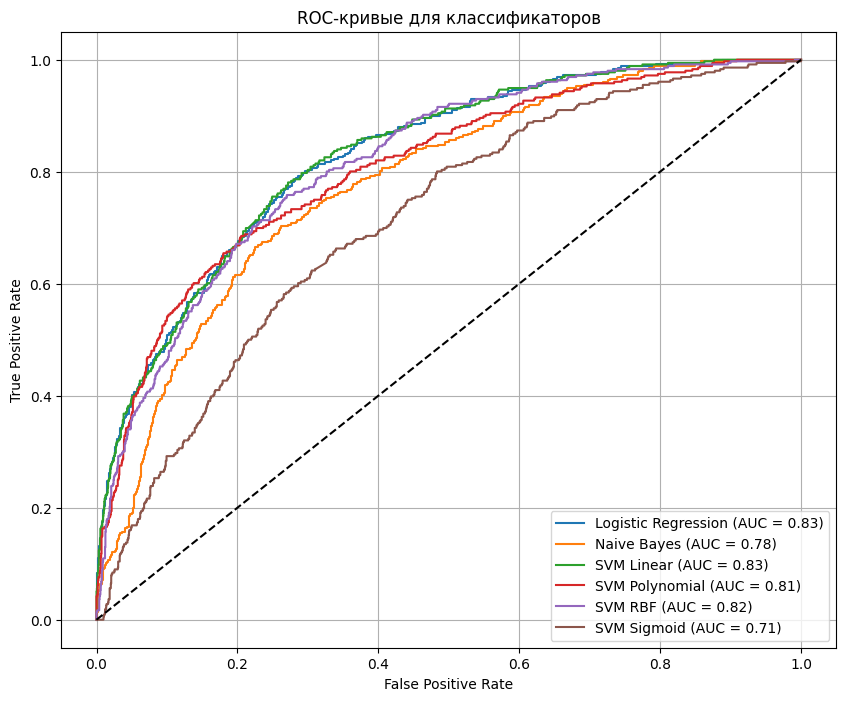

In [46]:
# Визуализация: ROC-кривые
plt.figure(figsize=(10, 8))
for name, (fpr, tpr, roc_auc) in roc_data.items():
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые для классификаторов')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

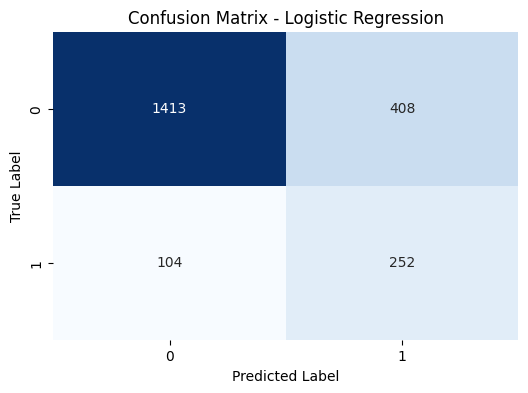

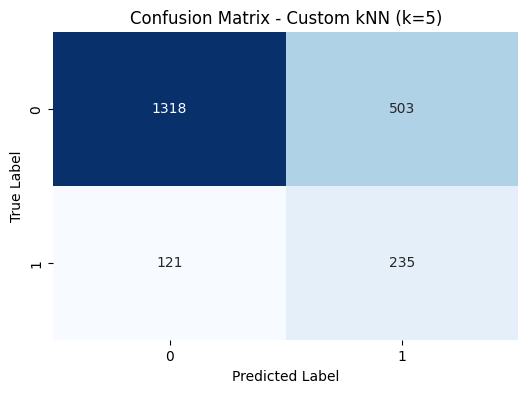

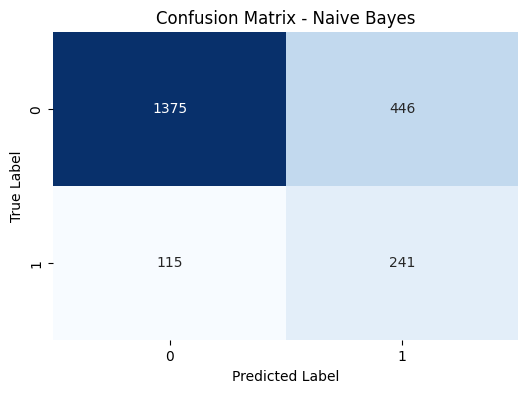

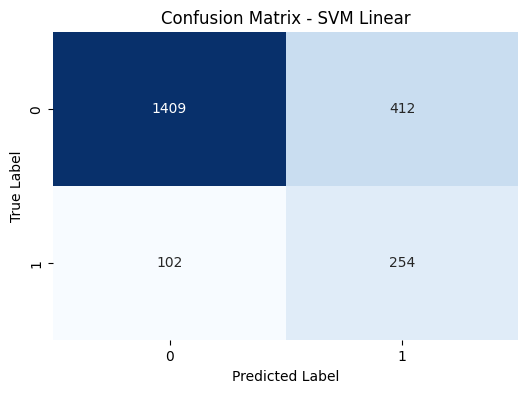

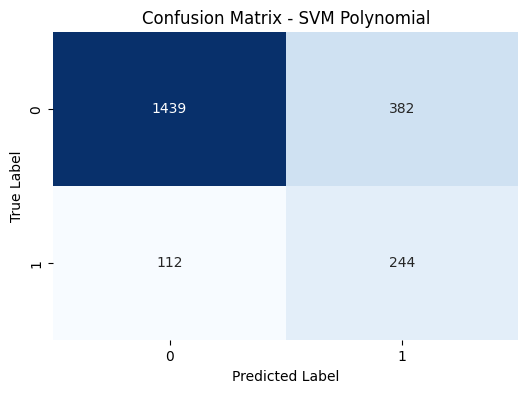

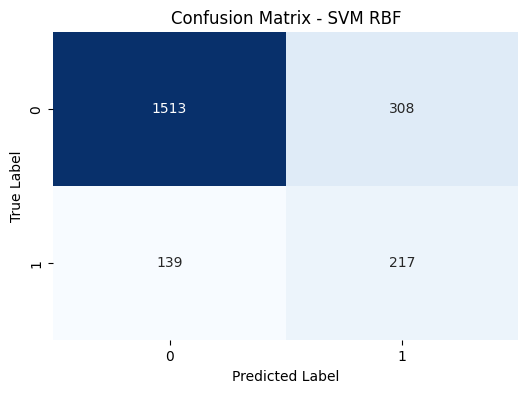

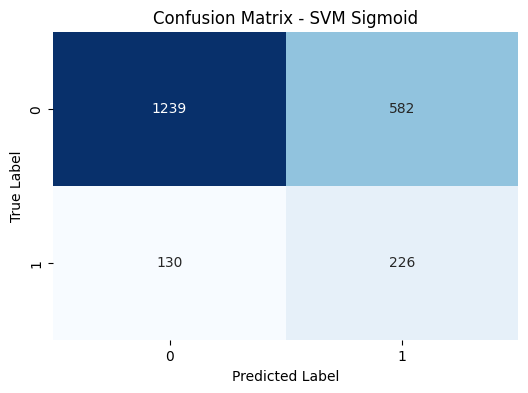

In [47]:
# Визуализация: Матрицы ошибок
for name, metrics in results.items():
    cm = metrics['Confusion Matrix']
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [48]:
# Вывод результатов
print("Метрики качества классификации:")
for name, metrics in results.items():
    print(f"\n{name}:")
    print(f"Accuracy: {metrics['Accuracy']:.3f}")
    print(f"Precision: {metrics['Precision']:.3f}")
    print(f"Recall: {metrics['Recall']:.3f}")
    print(f"F1 Score: {metrics['F1']:.3f}")
    if 'ROC AUC' in metrics:
        print(f"ROC AUC: {metrics['ROC AUC']:.3f}")


Метрики качества классификации:

Logistic Regression:
Accuracy: 0.765
Precision: 0.382
Recall: 0.708
F1 Score: 0.496
ROC AUC: 0.828

Custom kNN (k=5):
Accuracy: 0.713
Precision: 0.318
Recall: 0.660
F1 Score: 0.430

Naive Bayes:
Accuracy: 0.742
Precision: 0.351
Recall: 0.677
F1 Score: 0.462
ROC AUC: 0.779

SVM Linear:
Accuracy: 0.764
Precision: 0.381
Recall: 0.713
F1 Score: 0.497
ROC AUC: 0.829

SVM Polynomial:
Accuracy: 0.773
Precision: 0.390
Recall: 0.685
F1 Score: 0.497
ROC AUC: 0.807

SVM RBF:
Accuracy: 0.795
Precision: 0.413
Recall: 0.610
F1 Score: 0.493
ROC AUC: 0.817

SVM Sigmoid:
Accuracy: 0.673
Precision: 0.280
Recall: 0.635
F1 Score: 0.388
ROC AUC: 0.712


- **SVM Linear**, по-видимому, является лучшей моделью в целом с наивысшим показателем F1 (0,484), наивысшей полнотой (0,692) и наивысшей ROC AUC (0,798). Она обеспечивает надежный баланс между выявлением истинно положительных результатов (высокая полнота) и общей производительностью.
- **SVM RBF** является сильной альтернативой, если приоритетами являются точность (0,377) и минимизация ложных положительных результатов (FP: 101), поскольку она также имеет наивысшую точность (0,775).
- **Logistic Regression** является близким конкурентом с сильными метриками по всем направлениям (F1: 0,475, ROC AUC: 0,797) и может быть предпочтительнее для интерпретируемости.